# Network connection latency and capacity estimations from asymetric measurements
Antoine Saget - January 2021 - MoSIG SMPE peer review

In this report we perform linear regression over ping data on a local and a foreign website in order to estimate the parameters L and C of a very simple linear model describing the performance of a network connection.
The model is $T(S) = L + S/C$: the time $T(S)$ for a given message of size $S$ to be sent is approximated as the sum of the connection latency $L$ and the quotient of the message size $S$ divided by the bandwidth. The units used throughout the report are always bytes and milliseconds.

- In part one, the data is extracted from the dowloaded raw data. 
- Then the data analysis is performed for the first dataset in the second part. 
- The same analysis (but less thoroughly) is performed for the second dataset in the third part. 
- Finally, a quick comparison and conclusion is given in part four.

## 1 - Data preparation

In [1]:
# Necessary import and initialization for the notebook
 
import numpy as np 
import pandas as pd
import plotnine as plt 
import wget
import gzip
import random
import statsmodels.api as sm

from pathlib import Path
from datetime import datetime, timedelta
from plotnine import ggplot, aes, geom_point, geom_line, theme_bw, theme, geom_hline, labs, scale_x_datetime, geom_vline, geom_smooth, scale_y_continuous, geom_ribbon, element_text

from mizani.breaks import date_breaks
from mizani.formatters import date_format

random.seed(1582)

The first dataset consist of ping result to the liglab website. The data retrieving/extracting/preparation step is detailed in the following. For the sake of clarity it's only done for the first dataset but we'll apply the same treatment in part three for the second dataset.

In [2]:
# Downloading the data
url_liglab2 = 'http://mescal.imag.fr/membres/arnaud.legrand/teaching/2014/RICM4_EP_ping/liglab2.log.gz'
filename_liglab2 = 'liglab2'

def download_if_necessary(filename, url):
    if not Path(filename).is_file():
        wget.download(url, filename)
        print(f'{filename} downloaded.')
    else:
        print(f'{filename} already existing !')

download_if_necessary(filename_liglab2, url_liglab2)

liglab2 already existing !


In [3]:
def make_df(filename):
    # Reading raw data
    f = gzip.open(filename,'rt')
    data = f.readlines()
    print('Raw data sample:')
    print(data[:5])

    # Extracting needed informations + creation of a dataframe
    data = [line.split(' ') for line in data]
    data = [[datetime.fromtimestamp(float(line[0][1:-1])), int(line[1]), float(line[8].split('=')[1]) if len(line) > 8 else np.nan] 
                    for line in data]
    df = pd.DataFrame(
        data,
        columns=['date', 'size', 'time']
    )

    print('\nExtracted dataframe sample:')
    print(df[:5])
    f.close()
    return df

df_liglab2 = make_df(filename_liglab2)

Raw data sample:
['[1421761682.052172] 665 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=22.5 ms\n', '[1421761682.277315] 1373 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=21.2 ms\n', '[1421761682.502054] 262 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=21.2 ms\n', '[1421761682.729257] 1107 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=23.3 ms\n', '[1421761682.934648] 1128 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=1.41 ms\n']

Extracted dataframe sample:
                        date  size   time
0 2015-01-20 14:48:02.052172   665  22.50
1 2015-01-20 14:48:02.277315  1373  21.20
2 2015-01-20 14:48:02.502054   262  21.20
3 2015-01-20 14:48:02.729257  1107  23.30
4 2015-01-20 14:48:02.934648  1128   1.41


In [4]:
# Checking if the data is correct
def check_df(df):
    now = datetime.now()
    for index, row in df.iterrows():
        assert(row['date'] >= datetime.min) # The date should be between now and the minimum
        assert(row['date'] <= now)

        assert(row['size'] > 0) # A message cannot contains a negative number of bytes

        assert(pd.isnull(row['time']) or row['time'] > 0) # The time is either not existing or positive
    print('Dataframe checked.')
check_df(df_liglab2)

Dataframe checked.


Now that our data is prepared let's check the datapoints with missing time values so that we can make a decision. In this case, the time data is crucial and the only possible decision seems to discard those datapoints.
However, it's still interesting to understand how much data is missing and what caused this missing data:

In [5]:
# Looking at the data where the time is missing
def count_missing(df):
    is_NaN = df.isnull()
    row_has_NaN = is_NaN.any(axis=1)
    missing = df[row_has_NaN]

    missing_count = len(missing)
    n = len(df)
    missing_ratio = missing_count * 100.0 / n

    print(f'Data is missing for {missing_count} rows over a total of {n} rows : {missing_ratio:.2f}%.')
    
count_missing(df_liglab2)

Data is missing for 377 rows over a total of 44413 rows : 0.85%.


The missing data represent 0.85% of the total data. Let's check if the missing data is widespread across time and ping sizes or not:

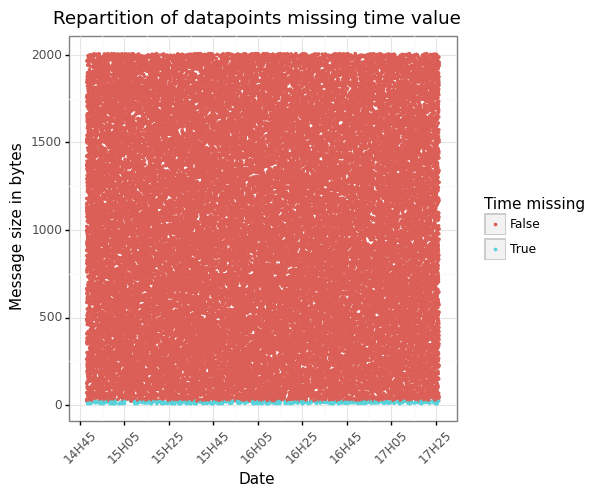

In [6]:
def plot_missing(df):
    is_NaN = df.isnull()
    row_has_NaN = is_NaN.any(axis=1)
    (
        ggplot(df)
        + aes(x='date', y='size', color=row_has_NaN)
        + theme_bw()
        + geom_point(size=0.5)
        + theme(figure_size=(5, 5), axis_text_x=element_text(angle=45))
        + labs(x='Date', y='Message size in bytes', color='Time missing', title='Repartition of datapoints missing time value')
        + scale_x_datetime(breaks=date_breaks('20 minutes'), labels=date_format('%HH%M'))
    ).draw()

plot_missing(df_liglab2)

We can see that data is always missing when the message size is small. And when trying the following ping command `ping 127.0.0.1 -s 15 -v -D` there is no time prompted while there is one for `ping 127.0.0.1 -s 16 -v -D` so we will ignore those little sizes as we have no time data for them.

> Also, from the previous plot we can note that the messages sizes seems uniformly sampled throught time, this should help reducing the potential bias added by a perturbation in the communication by applying perturbations to all message sizes.

In [7]:
# Removing datapoints with missing times
def remove_missing(df):
    is_NaN = df.isnull()
    row_has_NaN = is_NaN.any(axis=1)
    return df[np.invert(row_has_NaN)]

df_liglab2 = remove_missing(df_liglab2)

Our data is now ready, we can start analyzing it.

## 2 - Data analysis

First, we give an overview of the data and then perform a linear regression to estimate L and C.
### a. Overview

In [8]:
print(df_liglab2.date.min())
print(df_liglab2.date.max())
df_liglab2.describe()

2015-01-20 14:48:02.052172
2015-01-20 17:26:26.840222


,size,time
count,44036.000000,44036.000000
mean,1000.025729,5.136663
std,573.659666,12.221312
min,24.000000,1.000000
25%,499.000000,1.270000
50%,989.000000,1.440000
75%,1499.000000,2.310000
max,2007.000000,276.000000


We can see that:
- the messages sizes range from 24 to 2007 bytes
- the response time range from 1 to 276 milliseconds with an average of 5ms~
- the experiments consist of 44036 valid datapoints 
- the experiments occured the 20th of January 2015 between 14h48 and 17h26 (3h~)

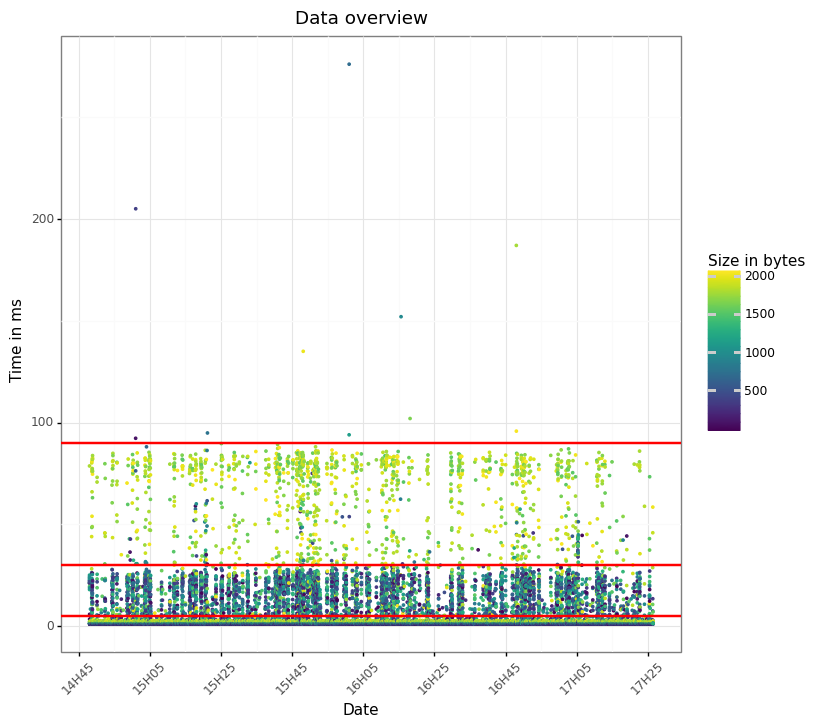

In [9]:
def plot_overview(df, l1, l2, l3):
    (
        ggplot(df)
        + aes(x='date', y='time', color='size')
        + theme_bw()
        + geom_point(size=0.5)
        + theme(figure_size=(8, 8), axis_text_x=element_text(angle=45))
        + geom_hline(yintercept = l1, color='red', size=1)
        + geom_hline(yintercept = l2, color='red', size=1)
        + geom_hline(yintercept = l3, color='red', size=1)
        + labs(x='Date', y='Time in ms', color='Size in bytes', title='Data overview')
        + scale_x_datetime(breaks=date_breaks('20 minutes'), labels=date_format('%HH%M'))
    ).draw()
    
plot_overview(df_liglab2, 5, 30, 90)

This first plot gives us a first overview of the data. We can distinguish 4 zones already (delimited arbitrarily by the red lines):
- on the top, few datapoints of varying sizes but with a long response time. Probably points resulting from perturbation in the communication.
- then, below, many datatpoints of long message (>1000 bytes) with a relatively long response time between 30 and 90ms
- below, many datapoints of medium and short messages with a relatively short response time
- and finally, what seems to be many datapoints of all sizes with a very short response time

We will try to investigate those four zones in the following of the analysis.
But first we will assess the stability of the communication over time by plotting the response time for given message sizes throught time:

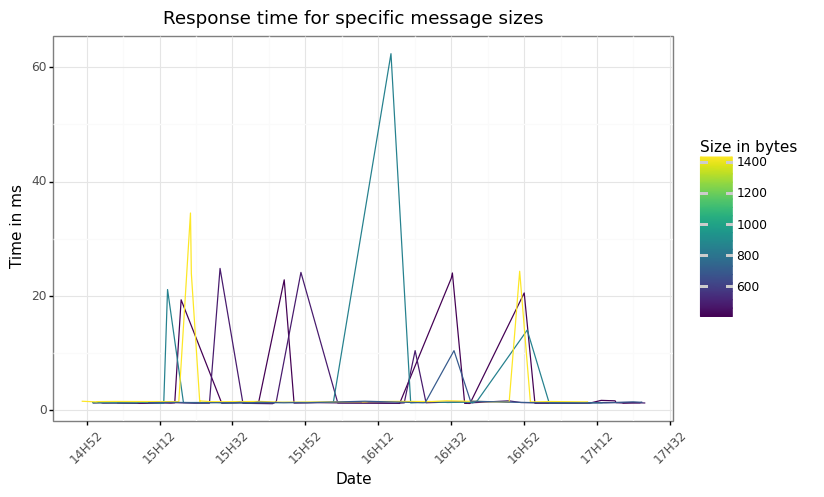

In [10]:
def plot_specific_sizes(df, curves):
    p = (
        ggplot(df)
        + aes(x='date',y='time', colour='size')
        + theme_bw()
        + theme(figure_size=(8, 5), axis_text_x=element_text(angle=45))
        + labs(x='Date', y='Time in ms', color='Size in bytes', title='Response time for specific message sizes')
        + scale_x_datetime(breaks=date_breaks('20 minutes'), labels=date_format('%HH%M'))
    )
    
    for c in curves : 
        p += geom_line(df[df['size'] == c])

    p.draw()
    
curves = random.choices(list(set(df_liglab2['size'])), k=5)
plot_specific_sizes(df_liglab2, curves)                                  

We can see that most value for a given size are below 10ms! There is no doubt that value above 100ms in the previous plot are instabilities in the communication. However, the two zones from 30~ to 90~ ms and from 10~ to 30~ ms that we identified earlier are intringuing. Let's look at previous overview plot but with a smaller timescale:

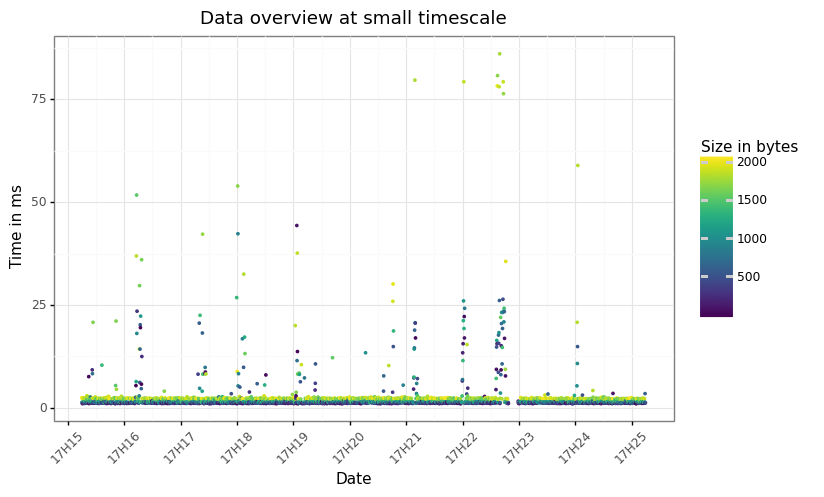

<ggplot: (8794079062980)>

In [11]:
# pick a random interval to look at
timemin = random.choice(df_liglab2['date'])
timemax = timemin + timedelta(minutes=10)

(
    ggplot(df_liglab2[(df_liglab2['date'] > timemin) & (df_liglab2['date'] < timemax)])
    + aes(x='date', y='time', color='size')
    + theme_bw()
    + geom_point(size=0.5)
    + theme(figure_size=(8, 5), axis_text_x=element_text(angle=45))
    + labs(x='Date', y='Time in ms', color='Size in bytes', title='Data overview at small timescale')
    + scale_x_datetime(breaks=date_breaks('1 minute'), labels=date_format('%HH%M'))
)

We can see that what seems to occur everywhere in the first overview plot with the full time scale here appears as spikes of slowdown than we can interpret as perturbation in the communication. Bigger messages are slower than smaller ones but both of them are much slower than the usual response time when there is no perturbation. 

Let's approximate quickly how much data is perturbated compared to "normal" data by counting the proportion of datapoint above 5ms (eyeball approximate just to have an insight):

In [12]:
def proportion_above(df, t):
    nabove = len(df[df['time'] > t])
    n = len(df)
    print(f'Proportion of datapoints slower than {t}ms : {nabove / n}', )
    
proportion_above(df_liglab2, 5)

Proportion of datapoints slower than 5ms : 0.1378190571350713


So, our data contains more than 13% of perturbated data. This is a lot, we can't discard those values, we will keep them while trying to infer L and C for our linear model. But we can already tell that the variability will be high and that our linear model is limited.

### b. Linear Regression

Before performing linear regression on the data, let's look at the time transmission evolution for increasing message sizes.

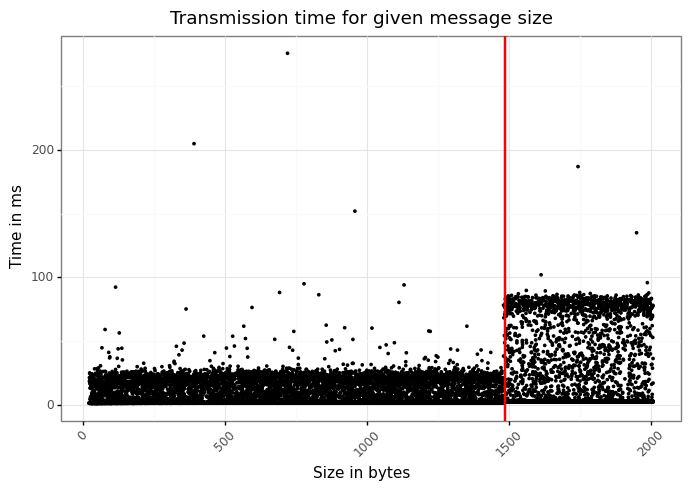

In [13]:
def plot_transmission_over_sizes(df):
    (
        ggplot(df)
        + aes(x='size', y='time')
        + theme_bw()
        + geom_point(size=0.5)
        + theme(figure_size=(8, 5), axis_text_x=element_text(angle=45))
        + geom_vline(xintercept = 1485, color='red', size=1)
        + labs(x='Size in bytes', y='Time in ms', title='Transmission time for given message size')
    ).draw()

plot_transmission_over_sizes(df_liglab2)

We see that times seems constant apart from a break at around 1485 bytes. This is due to the MTU (Maximum Transmission Unit) for Ethernet of 1500 bytes. When exceeding 1500 bytes for a packet (header + data), two packets are needed instead of one, therefore increasing the transmission time. This also explains why the time looks constant from 0~ to 1485~ bytes: the size doesn't matter, a single packet will be sent. The transmission times are also more variable after the 1485~ bytes treshold, this could be explained by the working of the icmp protocol used by ping.

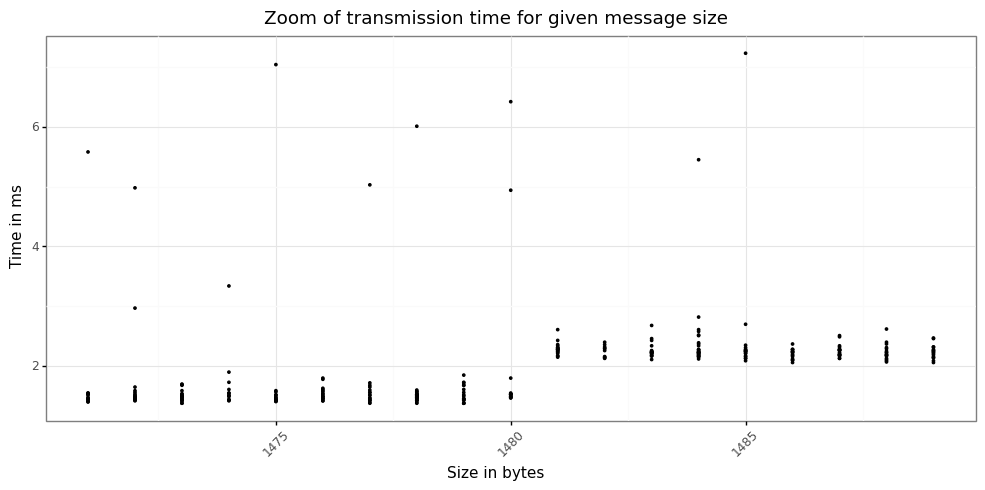

<ggplot: (8794077076715)>

In [14]:
(
    ggplot(df_liglab2[(df_liglab2['size']>1470) & (df_liglab2['size']<1490) & (df_liglab2['time']<10)])
    + aes(x='size', y='time')
    + theme_bw()
    + geom_point(size=0.5)
    + theme(figure_size=(12, 5), axis_text_x=element_text(angle=45))
    + labs(x='Size in bytes', y='Time in ms', title='Zoom of transmission time for given message size')
)

By zooming near the threshold we can see that the transition is between 1480 and 1481 bytes. We willl now perform two linear regressions, one for datapoints below 1481 bytes, one for datapoints above or equal 1481.

In [15]:
def create_and_fit(data):
    X = data['size']
    X = sm.add_constant(X)
    Y = data['time']
    return sm.OLS(Y, X).fit()

threshold = 1481    

fitted_one = create_and_fit(df_liglab2[df_liglab2['size'] < threshold])
print(f'First part, from 24 to {threshold} bytes:\n', fitted_one.summary())

fitted_two = create_and_fit(df_liglab2[df_liglab2['size'] >= threshold])
print(f'\nSecond part, from {threshold} to 2007 bytes:\n', fitted_two.summary())

First part, from 24 to 1481 bytes:
                             OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     14.75
Date:                Thu, 07 Jan 2021   Prob (F-statistic):           0.000123
Time:                        15:07:11   Log-Likelihood:            -1.0715e+05
No. Observations:               32667   AIC:                         2.143e+05
Df Residuals:                   32665   BIC:                         2.143e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3

From the summary we can see good p-values and confidence intervals for the first regression but not so much for the second one. We can also see that the "size" coefficient is low (0.0003 and 0.0026), which is expected as we saw earlier that the evolution of transmission time looked constant. And the constant is higher on the second regression (5.29 > 3.28) which is also expected as the transmission time take longer after 1481 bytes.

Let's plot those regression lines + the associated prediction intervals (couldn't find a straigforward way to compute regression line confidence intervals):

/home/antoine/.local/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 1318 rows containing missing values.


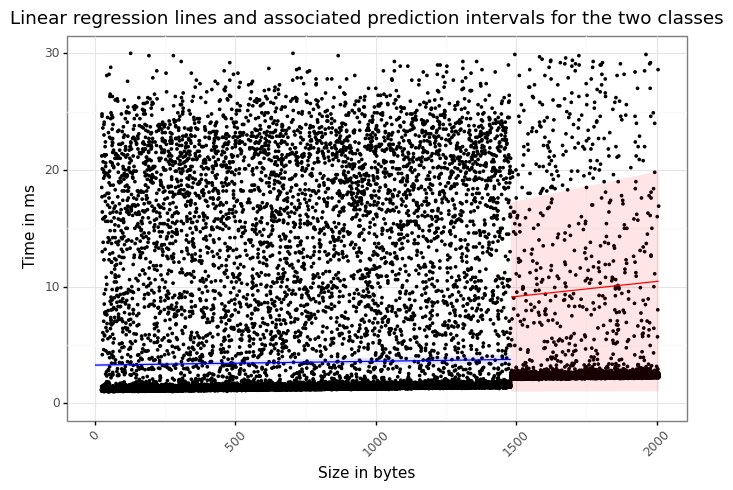

In [16]:
def plot_regression_lines(df, fitted_one, fitted_two, ymin, ymax):
    def pred(X, fitted):
        XX = sm.add_constant(X)

        conf = fitted.conf_int(alpha=0.05)
        ymin = X * conf[0][1] + conf[0][0] 
        ymax = X * conf[1][1] + conf[1][0]    

        return fitted.predict(XX), ymin, ymax

    X_one = np.linspace(0, threshold, 20)
    Y_one, Y_one_min, Y_one_max = pred(X_one, fitted_one)

    X_two = np.linspace(threshold, 2007, 20)
    Y_two, Y_two_min, Y_two_max = pred(X_two, fitted_two)

    df_reg1 = pd.DataFrame.from_dict({
        'size': X_one,
        'time': Y_one,
        'ymin': Y_one_min,
        'ymax': Y_one_max,
    })

    df_reg2 = pd.DataFrame.from_dict({
        'size': X_two,
        'time': Y_two,
        'ymin': Y_two_min,
        'ymax': Y_two_max,
    })

    (
        ggplot(df)
        + aes(x='size', y='time')
        + theme_bw()
        + geom_point(size=0.5)
        + theme(figure_size=(8, 5), axis_text_x=element_text(angle=45))
        + geom_line(data=df_reg1, color='blue')
        + geom_line(data=df_reg2, color='red')
        + scale_y_continuous(limits=(ymin, ymax))     
        + geom_ribbon(data=df_reg1, mapping=aes(ymin='ymin', ymax='ymax'), alpha=0.1, fill='blue')
        + geom_ribbon(data=df_reg2, mapping=aes(ymin='ymin', ymax='ymax'), alpha=0.1, fill='red')
        + labs(x='Size in bytes', y='Time in ms', title='Linear regression lines and associated prediction intervals for the two classes')
    ).draw()

plot_regression_lines(df_liglab2, fitted_one, fitted_two, 0, 30)

It's more clear visually how much more variable the second class is.
To conclude the analysis of the first dataset we can evaluate L and C for each classes by looking at the parameters learned during the linear regressions. However, it is important to keep in mind the confidence interval seen previously, espacially for the second class.
- under 1481 bytes : $T(S) = 3.2757 + S*0.0003$ : $L \approx 3.2757$ and $C \approx {1 \over 0.0003}$
- over 1481 bytes : $T(S) = 5.2898 + S*0.0026$ : $L \approx 5.2898$ and $C \approx {1 \over 0.0026}$

## 3 - Data analysis bis (stackoverflow)

The same data preparation and analysis as in part 1 and 2 is done here but with the second dataset that include ping result to the stackoverflow website.

### a. Data preparation

In [17]:
url_stackoverflow = 'http://mescal.imag.fr/membres/arnaud.legrand/teaching/2014/RICM4_EP_ping/stackoverflow.log.gz'
filename_stackoverflow = 'stackoverflow'
download_if_necessary(filename_stackoverflow, url_stackoverflow)

stackoverflow already existing !


In [18]:
df_stackoverflow = make_df(filename_stackoverflow)

Raw data sample:
['[1421771203.082701] 1257 bytes from stackoverflow.com (198.252.206.140): icmp_seq=1 ttl=50 time=120 ms\n', '[1421771203.408254] 454 bytes from stackoverflow.com (198.252.206.140): icmp_seq=1 ttl=50 time=120 ms\n', '[1421771203.739730] 775 bytes from stackoverflow.com (198.252.206.140): icmp_seq=1 ttl=50 time=126 ms\n', '[1421771204.056630] 1334 bytes from stackoverflow.com (198.252.206.140): icmp_seq=1 ttl=50 time=112 ms\n', '[1421771204.372224] 83 bytes from stackoverflow.com (198.252.206.140): icmp_seq=1 ttl=50 time=111 ms\n']

Extracted dataframe sample:
                        date  size   time
0 2015-01-20 17:26:43.082701  1257  120.0
1 2015-01-20 17:26:43.408254   454  120.0
2 2015-01-20 17:26:43.739730   775  126.0
3 2015-01-20 17:26:44.056630  1334  112.0
4 2015-01-20 17:26:44.372224    83  111.0


Dataframe checked.
Data is missing for 63 rows over a total of 6887 rows : 0.91%.


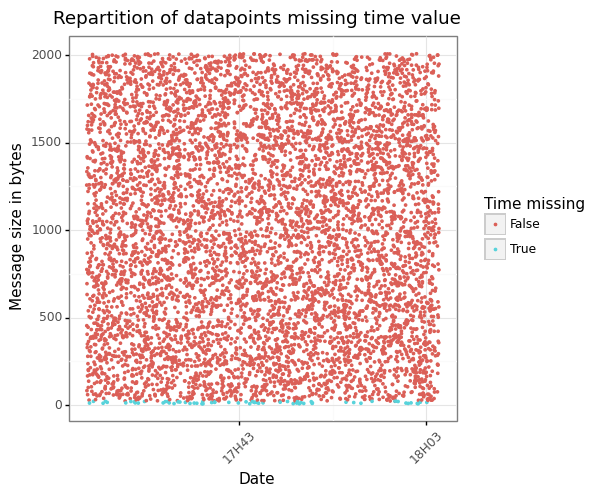

In [19]:
check_df(df_stackoverflow)
count_missing(df_stackoverflow)
plot_missing(df_stackoverflow)

We can see that the missing data for the stackoverflow dataset follow the same pattern as for the liglab2 dataset.

In [20]:
df_stackoverflow = remove_missing(df_stackoverflow)

### b. Data analysis

In [21]:
print(df_stackoverflow.date.min())
print(df_stackoverflow.date.max())
df_stackoverflow.describe()

2015-01-20 17:26:43.082701
2015-01-20 18:04:20.704382


,size,time
count,6824.000000,6824.000000
mean,1005.615475,114.230657
std,576.383830,8.056183
min,24.000000,110.000000
25%,498.000000,111.000000
50%,1001.500000,111.000000
75%,1510.000000,112.000000
max,2007.000000,163.000000


We can see that:
- the messages sizes range from 24 to 2007 bytes
- the response time range from 110 to 163 milliseconds with an average of 114ms~
- the experiments consist of 6824 valid datapoints 
- the experiments occured the 20th of January 2015 between 17h26 and 18h04 (30min)

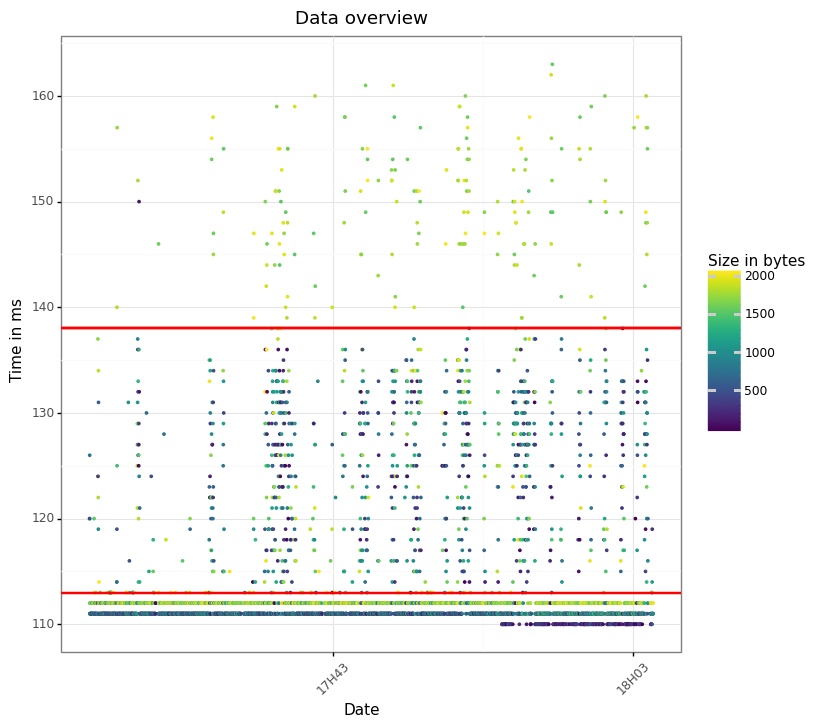

In [22]:
plot_overview(df_stackoverflow, 113, 138, 138)

There are fewer datapoints on this dataset, it's easier to see that most of the data is below 115ms and we can already see the gap after 1482 bytes

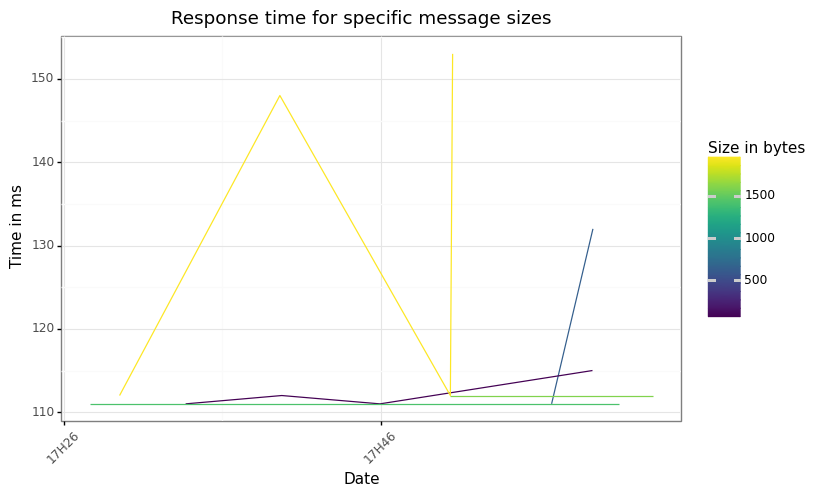

In [23]:
curves = random.choices(list(set(df_stackoverflow['size'])), k=5)
plot_specific_sizes(df_stackoverflow, curves)

There are too few datapoints of the same size for the plot to be meaningful, but we can conclude the same thing as before with the overview plot: most of the data is around 110 ms but perturbation in the communication slow down a portion of the experiment. Let's look how much data is perturbated:

In [24]:
proportion_above(df_stackoverflow, 115)

Proportion of datapoints slower than 115ms : 0.15313599062133645


Around 15% of our data is perturbated. Just like for the previous dataset, we will keep those values for the linear regressions.

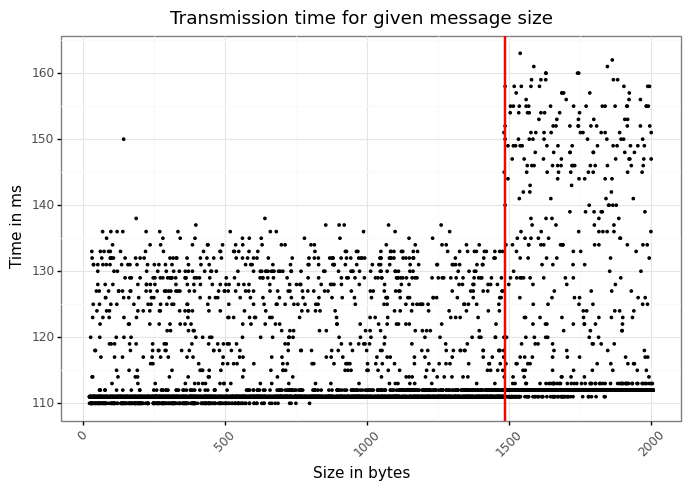

In [25]:
plot_transmission_over_sizes(df_stackoverflow)

The same jump at 1482 bytes occurs, we will do two linear regressions just like before:

In [26]:
fitted_one = create_and_fit(df_stackoverflow[df_stackoverflow['size'] < threshold])
print(f'First part, from 24 to {threshold} bytes:\n', fitted_one.summary())

fitted_two = create_and_fit(df_stackoverflow[df_stackoverflow['size'] >= threshold])
print(f'\nSecond part, from {threshold} to 2007 bytes:\n', fitted_two.summary())

First part, from 24 to 1481 bytes:
                             OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.05442
Date:                Thu, 07 Jan 2021   Prob (F-statistic):              0.816
Time:                        15:10:10   Log-Likelihood:                -15946.
No. Observations:                5015   AIC:                         3.190e+04
Df Residuals:                    5013   BIC:                         3.191e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        113

From the summary we can see good p-values for the constant term but not for the "size". The "size" coefficient is close to 0 (4.5e-05 and -0.0018) as expected so there is no problem with the high p-value. The constant is higher on the second regression (120 > 113) which is also expected as the transmission time take longer after 1481 bytes.

Let's plot those regression lines + the associated prediction intervals:

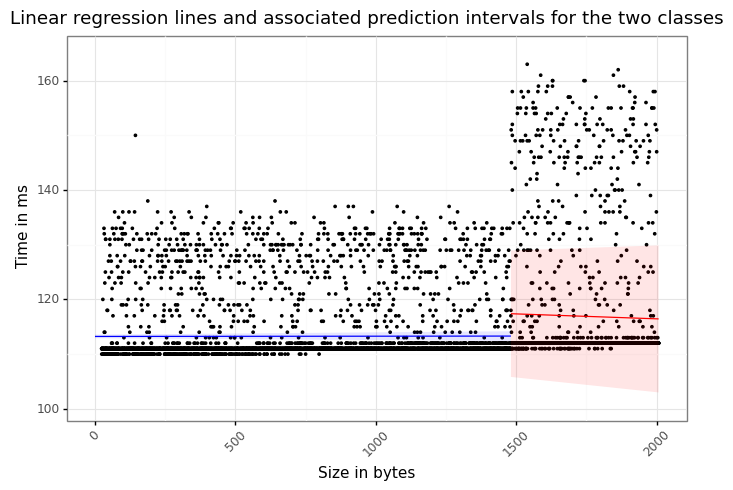

In [27]:
plot_regression_lines(df_stackoverflow, fitted_one, fitted_two, 101, 165)

We can see for the second regression line that the coefficient is negative. This doesn't really make sense for a communication to go faster as the message sizes are getting bigger and is probably due to a lack of datapoints.

To conclude the analysis of the second dataset we can evaluate L and C for each classes by looking at the parameters learned during the linear regressions. However, it is important to keep in mind the confidence interval seen previously, espacially for the second class.
- under 1481 bytes : $T(S) = 113.22 + S*4.5e-05$ : $L \approx 113$ and $C \approx {1 \over 4.5e-05}$
- over 1481 bytes : $T(S) = 120 - S*0.0018$ : $L \approx 120$ and $C \approx - {1 \over 0.0018}$ but a negative capacity doesn't make sense and it's better to think of C as $+\infty$ and T(S) = 120 constant for this range of time.

We can also look at the regression result when filtering the perturbated data. Here we discard any datapoints above 115ms:

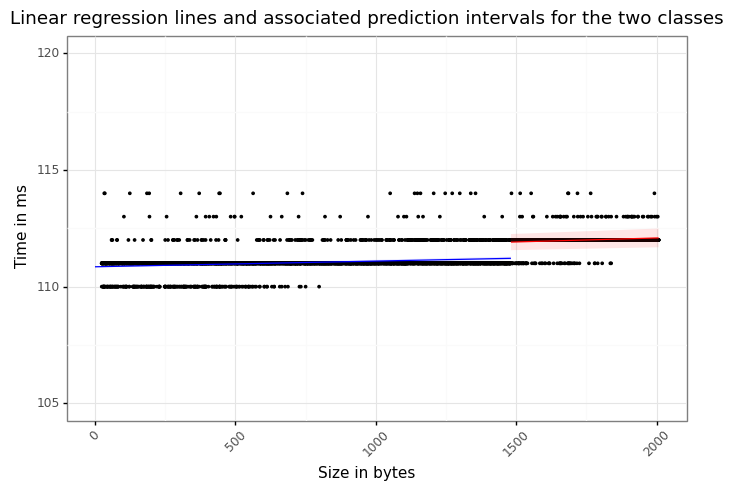

In [28]:
fitted_one = create_and_fit(df_stackoverflow[(df_stackoverflow['size'] < threshold) & (df_stackoverflow['time'] < 115)])
fitted_two = create_and_fit(df_stackoverflow[(df_stackoverflow['size'] >= threshold) & (df_stackoverflow['time'] < 115)])
plot_regression_lines(df_stackoverflow[df_stackoverflow['time'] < 115], fitted_one, fitted_two, 105, 120)

We can see that the lines make much more sense here and are in line with what whe expect. However, as the perturbated data represent about 15% of the total data one could argue that the pertubation should in fact be taken into account in the model and that discarding it would be better.

## 3 - Conclusion

First we can conclude that the communication to the foreign website is, as expected, slower that the close one. The slowdown comes from a increase in latency are the capacity C is comparable in both dataset and close to 0.

We also saw that the analysis is limited by the amount of data, perturbation in the communication and also the range of chosen sizes. For a better analysis, data ranging from few bytes to few megabytes would give more information on the network performance.
